<a href="https://colab.research.google.com/github/soconzan/2024-2-dl/blob/main/model-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 라이브러리 설치

In [1]:
pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 2.1 MB/s eta 0:00:00


---
### 데이터 로드
- FinanceDataReader 삼성 주가 사용
- 2019 ~ 2024.09.01

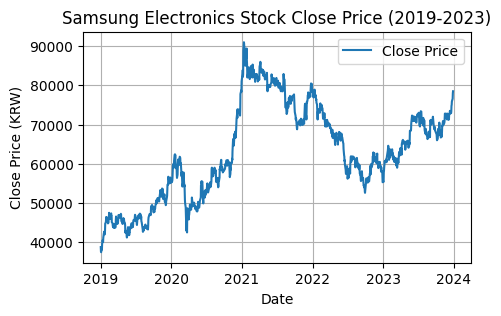

             Open   High    Low  Close    Volume    Change
Date                                                      
2019-01-02  39400  39400  38550  38750   7847664  0.001292
2019-01-03  38300  38550  37450  37600  12471493 -0.029677
2019-01-04  37450  37600  36850  37450  14108958 -0.003989
2019-01-07  38000  38900  37800  38750  12748997  0.034713
2019-01-08  38000  39200  37950  38100  12756554 -0.016774


In [2]:
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

df = fdr.DataReader('005930', start='2019-01-01', end='2023-12-31')

plt.figure(figsize=(5, 3))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Samsung Electronics Stock Close Price (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.show()

print(df.head())

---
### 데이터 정규화 (전처리)
- Close 값 사용
- MinMaxScaler : 0~1 사이로 정규화

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# MinMaxScaler
data = df[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

### 학습 및 테스트 세트 분리
- 8 : 2

In [4]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

---
### LSTM 모델 학습 데이터셋
- 과거 60일치 데이터를 사용하여 다음 날 Close값 예측

In [5]:
# LSTM 모델 학습을 위한 데이터 준비 (n일치의 데이터를 사용하여 다음 날 예측)
def create_dataset(data, n_steps=60):
    x, y = [], []
    for i in range(len(data) - n_steps - 1):
        a = data[i:(i + n_steps), 0]
        x.append(a)
        y.append(data[i + n_steps, 0])
    return np.array(x), np.array(y)

n_steps = 60 # 60일
x_train, y_train = create_dataset(train_data, n_steps)
x_test, y_test = create_dataset(test_data, n_steps)

### LSTM 학습 데이터 재구성
- 3차원 변환 [samples, timesteps, features]

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

---
### LSTM 모델 구축

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

### 모델 학습

In [8]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=1)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0100
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 0.0018
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0013
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - loss: 7.9182e-04
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 8.5025e-04
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0010
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 5.6181e-04
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 7.4886e-04
Epoch 9/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 5.9848e-04
Epoch 10/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 6.9896e-04


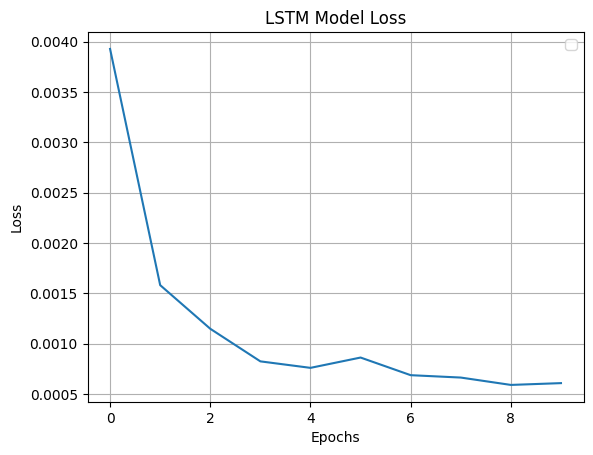

In [9]:
import matplotlib.pyplot as plt

# 학습 결과 시각화
plt.plot(history.history['loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

---
### 학습된 모델 예측 확인

In [10]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [11]:
# 예측 값의 변환 복원
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

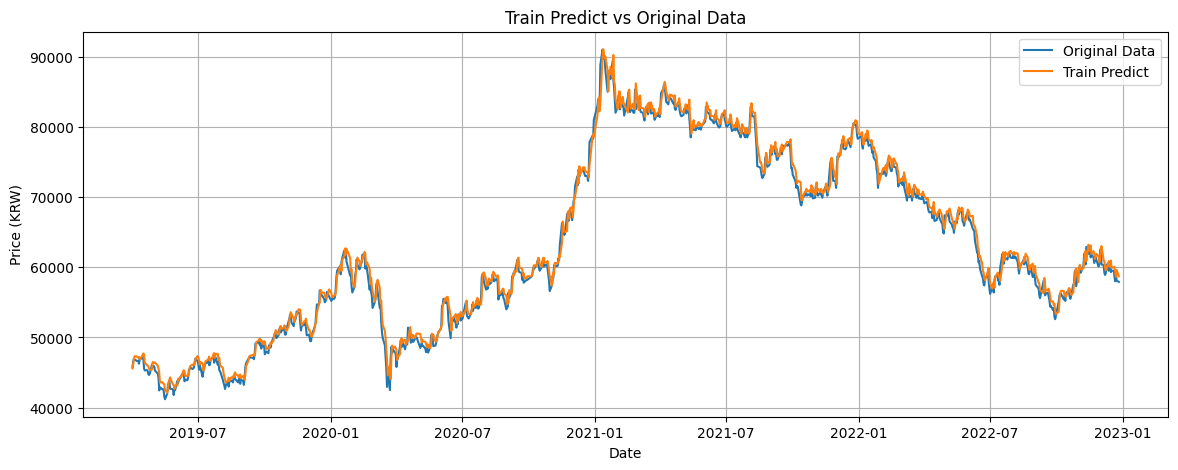

In [12]:
import matplotlib.pyplot as plt

train_range = data.index[n_steps:len(train_predict) + n_steps]

plt.figure(figsize=(14, 5))

plt.plot(train_range, scaler.inverse_transform(scaled_data[n_steps:len(train_predict) + n_steps]), label='Original Data')
plt.plot(train_range, train_predict, label='Train Predict')

plt.title('Train Predict vs Original Data')
plt.xlabel('Date')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)

plt.show()

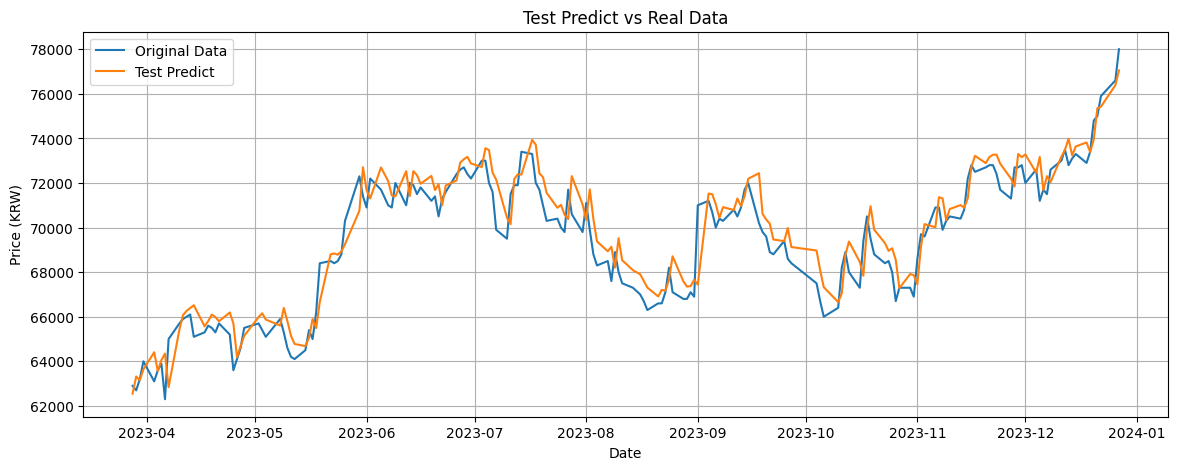

In [13]:
import matplotlib.pyplot as plt

test_range = data.index[len(train_predict) + (n_steps * 2) + 1:len(scaled_data) - 1]

plt.figure(figsize=(14, 5))

plt.plot(test_range, scaler.inverse_transform(scaled_data[len(train_predict) + (n_steps * 2) + 1:len(scaled_data) - 1]), label='Original Data')
plt.plot(test_range, test_predict, label='Test Predict')

plt.title('Test Predict vs Real Data')
plt.xlabel('Date')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)

plt.show()

---
### 결정계수 확인

In [14]:
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train.flatten(), train_predict.flatten())
test_r2 = r2_score(y_test.flatten(), test_predict.flatten())

print(f"Train R² score: {train_r2}")
print(f"Test R² score: {test_r2}")

Train R² score: 0.9923653953150434
Test R² score: 0.9022435322063573


---
### 2024년 예측하기

In [15]:
# import numpy as np

# # 미래 예측을 위한 n_steps일 간의 가장 최신 데이터를 가져오기 (2023년 마지막 n_steps일)
# last_n_days = scaled_data[-n_steps:]  # 가장 최근 n_steps 데이터를 사용

# # 미래 예측 데이터 리스트
# future_predict = []
# future_days = 30

# # 롤링 예측
# for i in range(future_days):
#     # 마지막 n_steps 데이터를 reshape하여 모델에 입력
#     last_n_days_reshaped = last_n_days.reshape(1, n_steps, 1)

#     # 다음 날 예측
#     predicted_value = model.predict(last_n_days_reshaped)

#     # 예측된 값을 저장
#     future_predict.append(predicted_value[0, 0])

#     # 예측 값을 입력에 포함시키기 위해 last_n_days를 업데이트 (슬라이딩 윈도우)
#     last_n_days = np.append(last_n_days[1:], predicted_value, axis=0)

# # 예측한 값을 원래 스케일로 변환
# future_predict = np.array(future_predict).reshape(-1, 1)
# future_predict_rescaled = scaler.inverse_transform(future_predict)

# # 결과 출력
# print("Future Predicted Prices:", future_predict_rescaled)

In [16]:
# # 예측 결과 시각화
# plt.figure(figsize=(10, 5))

# plt.plot(range(future_days), future_predict_rescaled, label='Future Predicted Prices')
# plt.title('Predicted Future Prices')
# plt.xlabel('Days')
# plt.ylabel('Price (KRW)')
# plt.legend()
# plt.grid(True)

# plt.show()

In [17]:
# df_2024_jan = fdr.DataReader('005930', start='2024-01-01', end='2024-01-30')

# # 주가 데이터 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(df_2024_jan.index, df_2024_jan['Close'], label='2024 Jan Close Price')
# plt.title('Samsung Electronics Stock Close Price (2024 January)')
# plt.xlabel('Date')
# plt.ylabel('Close Price (KRW)')
# plt.legend()
# plt.grid(True)
# plt.show()